# Imports

In [2]:
import keras
import mdn
from scipy.stats import norm
from sklearn.metrics import classification_report
from sklearn.metrics import log_loss
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
from sklearn.metrics import roc_auc_score
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

Using TensorFlow backend.


# Load data

In [2]:
X_train = pd.read_csv('./data/X_train_normal.csv', usecols=['GAME_ID', 'GAME_TIME', 'HT_SCORE_DIFF','HT_POSS'])
X_test_internal = pd.read_csv('./data/X_test_internal_normal.csv', usecols=['GAME_ID', 'GAME_TIME', 'HT_SCORE_DIFF','HT_POSS'])
X_test_external = pd.read_csv('./data/X_test_external_normal.csv', usecols=['GAME_ID', 'GAME_TIME', 'HT_SCORE_DIFF','HT_POSS'])
Y_train = pd.read_csv('./data/Y_train_binary.csv')
Y_test_internal = pd.read_csv('./data/Y_test_internal_binary.csv')
Y_test_external = pd.read_csv('./data/Y_test_external_binary.csv')
train = pd.concat([X_train, Y_train], axis=1)
test_internal = pd.concat([X_test_internal, Y_test_internal], axis=1)
test_external = pd.concat([X_test_external, Y_test_external], axis=1)

# Define custom data generator for sequential data

In [3]:
# Define custom generator class for sequential data
# https://stackoverflow.com/questions/55116638/use-keras-timeseriesgenerator-function-to-generate-squence-group-by-some-id
# https://stanford.edu/~shervine/blog/keras-how-to-generate-data-on-the-fly
class DataGenerator(keras.utils.Sequence):
    #'Generates data for Keras'
    def __init__(self, data, length, batch_size=32):
        self.tgs = list()
        unique_game_ids = data['GAME_ID'].unique().tolist()
        for game_id in unique_game_ids:
            game_data = data[data['GAME_ID'] == game_id]
            final_score = game_data['OUTCOME'].values[0]
            # pad length - 1 zero rows to head game df
            zero_pad_game_id_df = pd.DataFrame(data=np.full((length-1, 1), game_id), columns=['GAME_ID'])
            zero_pad_zeros_df = pd.DataFrame(data=np.full((length-1, 3), 0), columns=['GAME_TIME', 'HT_SCORE_DIFF', 'HT_POSS'])
            zero_pad_final_score_df = pd.DataFrame(data=np.full((length-1, 1), final_score), columns=['OUTCOME'])
            zero_df = pd.concat([zero_pad_game_id_df, zero_pad_zeros_df, zero_pad_final_score_df], axis=1, sort=False)
            # pad extra tail row to game df
            game_tail = game_data.tail(1)
            zero_padded_game_data = pd.concat([zero_df, game_data, game_tail], sort=False)
            self.tgs.append(keras.preprocessing.sequence.TimeseriesGenerator(zero_padded_game_data[['GAME_TIME', 'HT_SCORE_DIFF', 'HT_POSS']].values, zero_padded_game_data['OUTCOME'].values, length, batch_size=batch_size))
            
        self.len = sum([len(tg) for tg in self.tgs])
        self.idx_i = list()
        self.idx_j = list()
        
        for i, tg in enumerate(self.tgs):
            self.idx_i.extend(list(range(len(tg))))
            self.idx_j.extend([i] * len(tg))
            
    def __len__(self):
        return self.len
    
    def __getitem__(self, index):
        return self.tgs[self.idx_j[index]][self.idx_i[index]]

# Create sequential data for model fitting

In [4]:
SEQ_LENGTH = 50
BATCH_SIZE = 32
train_gen = DataGenerator(train, SEQ_LENGTH, BATCH_SIZE)
test_internal_gen = DataGenerator(test_internal, SEQ_LENGTH, BATCH_SIZE)
test_external_gen = DataGenerator(test_external, SEQ_LENGTH, BATCH_SIZE)

In [5]:
print(train_gen[0][0].shape)

(32, 50, 3)


# Define neural network architecture

In [6]:
N_HIDDEN = 4
num_input_features = train_gen[0][0].shape[2]
model = keras.Sequential()
model.add(keras.layers.SimpleRNN(units=N_HIDDEN, input_shape=(SEQ_LENGTH, num_input_features), activation='tanh'))
model.add(keras.layers.Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer=keras.optimizers.Adam(), metrics=['accuracy', 'binary_accuracy'])
model.summary()

W0116 10:35:12.136530 4576601536 deprecation_wrapper.py:119] From /Users/henrypoole/anaconda3/envs/thesis-v2/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0116 10:35:12.163866 4576601536 deprecation_wrapper.py:119] From /Users/henrypoole/anaconda3/envs/thesis-v2/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0116 10:35:12.166172 4576601536 deprecation_wrapper.py:119] From /Users/henrypoole/anaconda3/envs/thesis-v2/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0116 10:35:12.257776 4576601536 deprecation_wrapper.py:119] From /Users/henrypoole/anaconda3/envs/thesis-v2/lib/python3.6/site-packages/keras/optimizers.py:790: The name tf.train.Optimizer is deprecated

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
simple_rnn_1 (SimpleRNN)     (None, 4)                 32        
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 5         
Total params: 37
Trainable params: 37
Non-trainable params: 0
_________________________________________________________________


# Fit model

In [7]:
model_fit = model.fit_generator(generator=train_gen, validation_data=test_internal_gen, epochs=5)

W0116 10:35:12.489551 4576601536 deprecation_wrapper.py:119] From /Users/henrypoole/anaconda3/envs/thesis-v2/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:986: The name tf.assign_add is deprecated. Please use tf.compat.v1.assign_add instead.



Epoch 1/5
64308/64308 [==============================] - 1506s 23ms/step - loss: 0.4800 - acc: 0.7536 - binary_accuracy: 0.7536 - val_loss: 0.5116 - val_acc: 0.7351 - val_binary_accuracy: 0.7351
Epoch 2/5
64308/64308 [==============================] - 1571s 24ms/step - loss: 0.4722 - acc: 0.7550 - binary_accuracy: 0.7550 - val_loss: 0.5004 - val_acc: 0.7388 - val_binary_accuracy: 0.7388
Epoch 3/5
64308/64308 [==============================] - 1631s 25ms/step - loss: 0.4714 - acc: 0.7551 - binary_accuracy: 0.7551 - val_loss: 0.5129 - val_acc: 0.7330 - val_binary_accuracy: 0.7330
Epoch 4/5
64308/64308 [==============================] - 1569s 24ms/step - loss: 0.4714 - acc: 0.7547 - binary_accuracy: 0.7547 - val_loss: 0.4994 - val_acc: 0.7388 - val_binary_accuracy: 0.7388
Epoch 5/5
64308/64308 [==============================] - 3724s 58ms/step - loss: 0.4708 - acc: 0.7554 - binary_accuracy: 0.7554 - val_loss: 0.5115 - val_acc: 0.7299 - val_binary_accuracy: 0.7299


# Save model

In [8]:
model_json = model.to_json()
with open("base_rnn_seq_length_{}_classification_model.json".format(SEQ_LENGTH), "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model.save_weights("base_rnn_seq_length_{}_classification_model.h5".format(SEQ_LENGTH))

# Plot training/validation loss

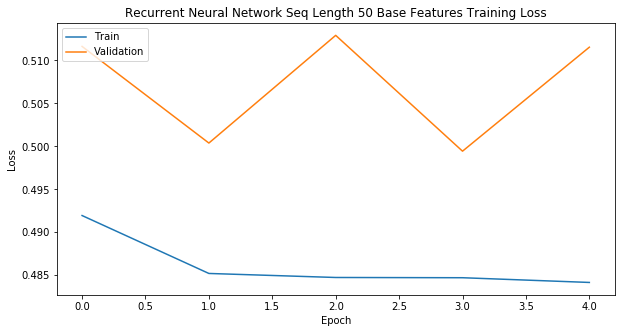

In [9]:
plt.figure(figsize=(10, 5))
plt.plot(model_fit.history['loss'])
plt.plot(model_fit.history['val_loss'])
plt.title('Recurrent Neural Network Seq Length {} Base Features Training Loss'.format(SEQ_LENGTH))
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Make binary class and probabilistic predictions

In [10]:
# Make probabilistic predictions
Y_train_prob_pred = model.predict_generator(train_gen)[:, 0]
Y_test_internal_prob_pred = model.predict_generator(test_internal_gen)[:, 0]
Y_test_external_prob_pred = model.predict_generator(test_external_gen)[:, 0]

# Convert to binary predictions
Y_train_class_pred = np.where(Y_train_prob_pred <= 0.5, 0, 1)
Y_test_internal_class_pred = np.where(Y_test_internal_prob_pred <= 0.5, 0, 1)
Y_test_external_class_pred = np.where(Y_test_external_prob_pred <= 0.5, 0, 1)

# Save predictions as .csv
Y_train_pred = pd.DataFrame({'class_pred':Y_train_class_pred, 'prob_pred':Y_train_prob_pred})
Y_train_pred.to_csv('./data/base_rnn_seq_length_{}_train_predictions.csv'.format(SEQ_LENGTH), index=False)

Y_test_internal_pred = pd.DataFrame({'class_pred':Y_test_internal_class_pred, 'prob_pred':Y_test_internal_prob_pred})
Y_test_internal_pred.to_csv('./data/base_rnn_seq_length_{}_test_internal_predictions.csv'.format(SEQ_LENGTH), index=False)

Y_test_external_pred = pd.DataFrame({'class_pred':Y_test_external_class_pred, 'prob_pred':Y_test_external_prob_pred})
Y_test_external_pred.to_csv('./data/base_rnn_seq_length_{}_test_external_predictions.csv'.format(SEQ_LENGTH), index=False)

In [11]:
print(Y_train_prob_pred)

[0.62987125 0.6333366  0.632997   ... 0.99419636 0.99419606 0.99419606]


# Evaluate Results

In [4]:
# Reload predictions and original labels
Y_train_pred = pd.read_csv('./data/base_rnn_seq_length_50_train_predictions.csv')
Y_test_internal_pred = pd.read_csv('./data/base_rnn_seq_length_50_test_internal_predictions.csv')
Y_test_external_pred = pd.read_csv('./data/base_rnn_seq_length_50_test_external_predictions.csv')
Y_train_prob_pred = Y_train_pred['prob_pred']
Y_train_class_pred = Y_train_pred['class_pred']
Y_test_internal_prob_pred = Y_test_internal_pred['prob_pred']
Y_test_internal_class_pred = Y_test_internal_pred['class_pred']
Y_test_external_prob_pred = Y_test_external_pred['prob_pred']
Y_test_external_class_pred = Y_test_external_pred['class_pred']
Y_train = pd.read_csv('./data/Y_train_binary.csv')
Y_test_internal = pd.read_csv('./data/Y_test_internal_binary.csv')
Y_test_external = pd.read_csv('./data/Y_test_external_binary.csv')

In [5]:
# Classification reports
train_classification_report = classification_report(Y_train, Y_train_class_pred, target_names=['Away Team Win', 'Home Team Win'], digits=4)
test_internal_classification_report = classification_report(Y_test_internal, Y_test_internal_class_pred, target_names=['Away Team Win', 'Home Team Win'], digits=4)
test_external_classification_report = classification_report(Y_test_external, Y_test_external_class_pred, target_names=['Away Team Win', 'Home Team Win'], digits=4)

In [6]:
print(train_classification_report)

               precision    recall  f1-score   support

Away Team Win     0.7785    0.4839    0.5968    779434
Home Team Win     0.7327    0.9113    0.8123   1209790

     accuracy                         0.7438   1989224
    macro avg     0.7556    0.6976    0.7046   1989224
 weighted avg     0.7506    0.7438    0.7279   1989224



In [7]:
print(test_internal_classification_report)

               precision    recall  f1-score   support

Away Team Win     0.8005    0.4961    0.6126     96760
Home Team Win     0.7042    0.9066    0.7926    128011

     accuracy                         0.7299    224771
    macro avg     0.7523    0.7013    0.7026    224771
 weighted avg     0.7456    0.7299    0.7151    224771



In [8]:
print(test_external_classification_report)

               precision    recall  f1-score   support

Away Team Win     0.7921    0.5058    0.6174    104262
Home Team Win     0.6859    0.8905    0.7749    126379

     accuracy                         0.7166    230641
    macro avg     0.7390    0.6981    0.6961    230641
 weighted avg     0.7339    0.7166    0.7037    230641



In [9]:
# Calculate log loss
train_log_loss = log_loss(Y_train, Y_train_prob_pred)
test_internal_log_loss = log_loss(Y_test_internal, Y_test_internal_prob_pred)
test_external_log_loss = log_loss(Y_test_external, Y_test_external_prob_pred)

In [10]:
print(train_log_loss)

0.4877640405882194


In [11]:
print(test_internal_log_loss)

0.5115490252078894


In [12]:
print(test_external_log_loss)

0.5173615175768851


In [15]:
# Calculate area under ROC curve

def plot_roc_curve(true, pred, title):
    fpr, tpr, threshold = roc_curve(true, pred)
    roc_auc = auc(fpr, tpr)
    plt.title('{} ROC Curve'.format(title))
    plt.plot(fpr, tpr, 'b', label = 'AUC = %0.4f' % roc_auc)
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()

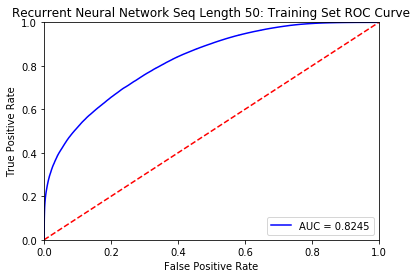

In [16]:
plot_roc_curve(Y_train, Y_train_prob_pred, 'Recurrent Neural Network Seq Length 50: Training Set')

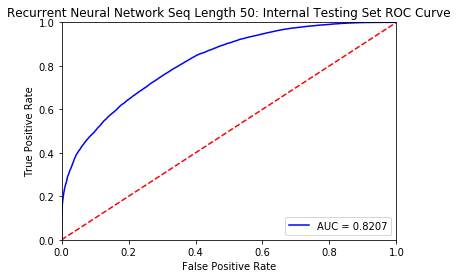

In [17]:
plot_roc_curve(Y_test_internal, Y_test_internal_prob_pred, 'Recurrent Neural Network Seq Length 50: Internal Testing Set')

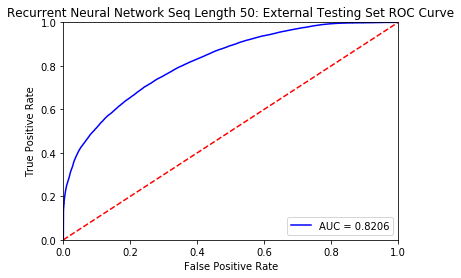

In [18]:
plot_roc_curve(Y_test_external, Y_test_external_prob_pred, 'Recurrent Neural Network Seq Length 50: External Testing Set')